## Computation of OOD pixels and Ground Truth Aleatoric Uncertainty

The aim of this notebook is to establish and visualise a method for determining a kind of "ground truth" labels for pixels induced by OOD variation in a controllable synthetic histopathological dataset. Similarly, the analysis is then reproduced for the aleatoric component, induced by simulating disagreement between annotators, shifting the analysis to the study of label distribution. 

This calculation refers to the results of the 'Applications' folder.

In [15]:
import os
import glob
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
import pandas as pd

from pathlib import Path
from PIL import Image
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from numpy import linalg as la

#### OOD pixels labeling for 'nuclei_intensity' and 'blood_cells' variations for the Arctique synthetic dataset (Neurips 2024)

In [42]:
NUCL_INT = {
    '1_00': '0_00',
    '0_75': '0_175',
    '0_50' : '0_35', 
    '0_25': '0_525',
    '0_00': '0_70'
}

task = "semantic" #['semantic', 'instance']
model_noise = 0
variation = "blood_cells" #['blood_cells', 'nuclei_intensity']
decomp = "pu"

data_noise_uq_maps = "0_75" 
uq_method = "tta" #["tta", "softmax", "ensemble"]
idx = 0

if variation == 'blood_cells':
    zero_risk_data, data_noise_img = "0_00", data_noise_uq_maps 
else:
    zero_risk_data, data_noise_img = NUCL_INT["0_00"], NUCL_INT[data_noise_uq_maps] #["0_25", "0_50", "0_75", "1_00"] 

In [43]:
data_path = Path("/home/vanessa/Documents/data/uncertainty_arctique_v1-0-corrected_14/UQ_maps")
metadata_path = Path("/home/vanessa/Documents/data/uncertainty_arctique_v1-0-corrected_14/UQ_metadata")
hovernext_path = Path(f'/home/vanessa/Desktop/synth_unc_models/data/v1-0-variations/variations/{variation}/')   

In [44]:
map_type = f"{task}_noise_{model_noise}_{variation}_{data_noise_uq_maps}_{uq_method}_{decomp}.npy"
map_file = data_path.joinpath(map_type)
print(f"Loading UQ map from: {map_file}")  # Debugging line
uq_maps = np.load(map_file)

# Load metadata
metadata_type = f"{task}_noise_{model_noise}_{variation}_{data_noise_uq_maps}_{uq_method}_{decomp}_sample_idx.npy"
metadata_file_path = metadata_path.joinpath(metadata_type)
metadata_file = np.load(metadata_file_path)
metadata_file[idx]

Loading UQ map from: /home/vanessa/Documents/data/uncertainty_arctique_v1-0-corrected_14/UQ_maps/semantic_noise_0_blood_cells_0_75_tta_pu.npy


308

In [45]:
def normalize_min_max(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):
    if mi is None:
        mi = np.min(x)
    if ma is None:
        ma = np.max(x)
    if dtype is not None:
        x = x.astype(dtype, copy=False)
        mi = dtype(mi) if np.isscalar(mi) else mi.astype(dtype, copy=False)
        ma = dtype(ma) if np.isscalar(ma) else ma.astype(dtype, copy=False)
        eps = dtype(eps)

    x = (x - mi) / (ma - mi + eps)

    if clip:
        x = np.clip(x, 0, 1)
    return x

In [46]:
img_file_ood = Path(hovernext_path).joinpath(f"{data_noise_img}/images/img_{metadata_file[idx]}.png")
img_file_id = Path(hovernext_path).joinpath(f"{zero_risk_data}/images/img_{metadata_file[idx]}.png")

img_ood = np.array(Image.open(img_file_ood)).astype(np.float32)[:,:,:3]
img_id = np.array(Image.open(img_file_id)).astype(np.float32)[:,:,:3]
img_ood = normalize_min_max(img_ood, 0, 255)
img_id = normalize_min_max(img_id, 0, 255)

# Calculate ground truth
red_diff = img_ood[:,:,0] - img_id[:,:,0]
green_diff = img_ood[:,:,1] - img_id[:,:,1]
blue_diff = img_ood[:,:,2] - img_id[:,:,2]

# First create the combined condition for red channel being greater than others
red_dominance = np.logical_and(
    red_diff > green_diff,
    red_diff > blue_diff
)

# Then combine with the condition that red difference should be positive
gt_ood = np.logical_and(
    red_diff > 0,
    red_dominance
)

# Convert to float32 after all logical operations are done
gt_ood = gt_ood.astype(np.float32)

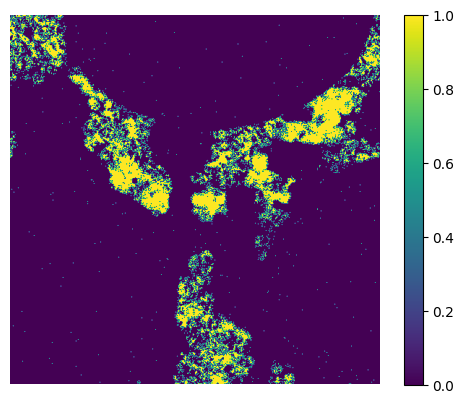

In [47]:
plt.imshow(gt_ood)
plt.axis('off')
plt.colorbar()  

In [48]:
gt_ood

array([[1., 1., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

##### Alternative way to compute OOD pixels, more prone to generalisation of variation 

In [49]:
img_file_ood = Path(hovernext_path).joinpath(f"{data_noise_img}/images/img_{metadata_file[idx]}.png")
img_file_id = Path(hovernext_path).joinpath(f"{zero_risk_data}/images/img_{metadata_file[idx]}.png")

img_ood = np.array(Image.open(img_file_ood)).astype(np.float32)[:,:,:3]
img_id = np.array(Image.open(img_file_id)).astype(np.float32)[:,:,:3]
img_ood = normalize_min_max(img_ood, 0, 255)
img_id = normalize_min_max(img_id, 0, 255)

gt_ood_norm = img_ood - img_id
ood_norm = la.norm(gt_ood_norm, 2, 2)
threshold = (np.max(ood_norm) - np.min(ood_norm))/2 if variation == 'blood_cells' else 0.1
print(threshold) #The threshold is a hyper-parameter that the user must fine-tune when using the synthetic dataset!
gt_ood_norm = (ood_norm > threshold).astype(int)


0.37580621242523193


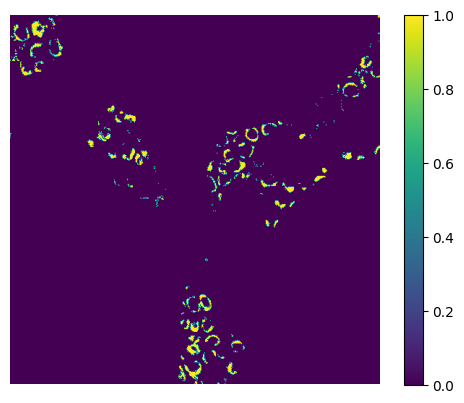

In [50]:
plt.imshow(gt_ood_norm)
plt.axis('off')
plt.colorbar()  

In [51]:
gt_ood_norm

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### Entropy soft-labels distribution for the instance and semantic masks of the Arctique synthetic dataset (Neurips 2024)

In [29]:
task = 'semantic'
model_noise = 40
random.seed(42)
idx = 0

label_path = '/home/vanessa/Desktop/synth_unc_models/data/v1-0-corrected_NOISY/test/masks/'

In [30]:
zero_au_label_path = label_path + f'{task}_noise_0/*.png'
au_label_path = label_path + f'{task}_noise_{model_noise}/*.png'

masks_zero_au_files = glob.glob(zero_au_label_path)
mask_noise_au_files = glob.glob(au_label_path)

# Select 50 random samples from masks_zero_au
random_samples = random.sample(masks_zero_au_files, 50)
# Extract the filenames (without directory)
selected_filenames = {os.path.basename(f) for f in random_samples}
# Find corresponding files in mask_noise_au
matching_masks = [f for f in mask_noise_au_files if os.path.basename(f) in selected_filenames]
matching_masks_zero = [f for f in masks_zero_au_files if os.path.basename(f) in selected_filenames]

In [31]:
mask_zero_au = np.array([np.array(Image.open(mask), dtype = int) for mask in matching_masks_zero])
mask_noise_au = np.array([np.array(Image.open(mask), dtype = int) for mask in matching_masks])

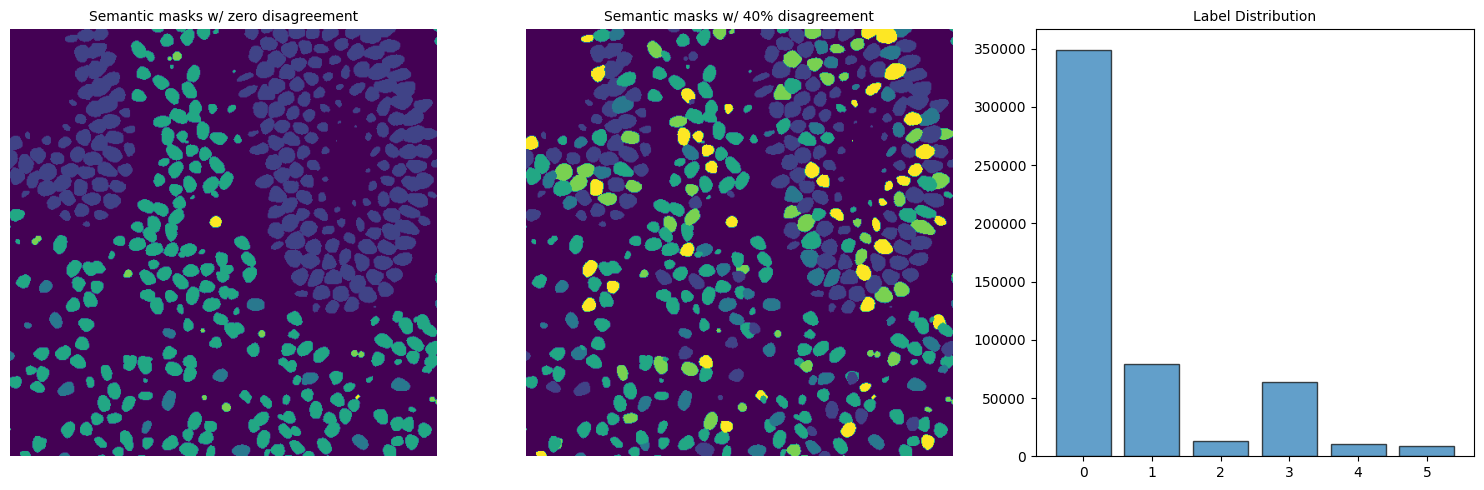

In [32]:
fig = plt.figure(figsize=(15, 5))  
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

ax0 = plt.subplot(gs[0])
ax0.imshow(mask_zero_au[idx])
ax0.axis("off")
ax0.set_title("Semantic masks w/ zero disagreement", fontsize=10)

ax1 = plt.subplot(gs[1])
ax1.imshow(mask_noise_au[idx])
ax1.axis("off")
ax1.set_title(f"Semantic masks w/ {model_noise}% disagreement", fontsize=10)

ax2 = plt.subplot(gs[2])
labels_combined = np.concatenate([mask_zero_au[idx].flatten(), mask_noise_au[idx].flatten()])  # Flatten and merge labels
unique_labels, counts = np.unique(labels_combined, return_counts=True)

ax2.bar(unique_labels, counts, edgecolor="black", alpha=0.7)  # Better aesthetics
ax2.set_title("Label Distribution", fontsize=10)
ax2.set_xticks(unique_labels) 

plt.tight_layout()
plt.show()

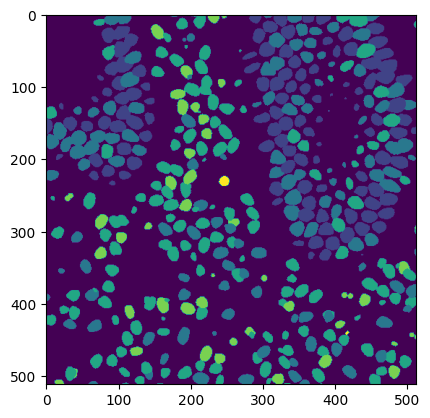

In [46]:
plt.imshow(np.round((mask_zero_au[idx] + mask_noise_au[idx])/ 2).astype(int))

In [47]:
np.unique(np.round((mask_zero_au[idx] + mask_noise_au[idx])/ 2).astype(int))

array([0, 1, 2, 3, 4, 5])

In [145]:
def entropy(probs: np.ndarray, axis: int = -1, eps: float = 1e-5) -> np.ndarray:
    """
    Computes the entropy of a probability distribution using NumPy.
    Args:
        probs (np.ndarray): The probability distribution array.
        axis (int): The axis along which to compute entropy.

    Returns:
        np.ndarray: The computed entropy.
    """
    log_probs = np.log(probs)

    # Handle numerical stability (avoid log(0) issue)
    min_real = np.finfo(log_probs.dtype).min
    log_probs = np.clip(log_probs, a_min=min_real, a_max=None)

    p_log_p = log_probs * probs

    return -np.sum(p_log_p, axis=axis)

In [146]:
# Compute label probabilities
probs = counts / counts.sum()  # Normalize to get probabilities
entropy(probs)

1.0475196764222932